# Social Media Mining
## Final Project

In [ ]:
# Author Divya Rajendran
import pandas as pd
import numpy as np
import datetime as dt

In [90]:
# read poll data into data frame
def read_poll_data(file_name):
    poll_df = pd.read_csv(file_name, index_col=None, header=0)
    # modify the date columns to be of the format Month-YYYY
    poll_df["startdate"] = pd.to_datetime(pd.Series(poll_df['startdate']), format="%d-%m-%Y")
    poll_df["enddate"] = pd.to_datetime(pd.Series(poll_df['enddate']), format="%d-%m-%Y")
    poll_df['startdate'] = poll_df['startdate'].apply(lambda x: x.strftime('%B-%Y')) 
    poll_df["enddate"] = poll_df['enddate'].apply(lambda x: x.strftime('%B-%Y')) 
    poll_df["startdate"] = pd.to_datetime(pd.Series(poll_df['startdate']), format="%B-%Y")
    poll_df["enddate"] = pd.to_datetime(pd.Series(poll_df['enddate']), format="%B-%Y")
    
    clinton_poll_df = poll_df.groupby(['poll_id','state', "startdate", "enddate"], as_index=False)['adjpoll_clinton'].mean()
    clinton_polls_df = poll_df.groupby(["poll_id", "startdate", "enddate", "state"]).size().reset_index().rename(columns={0: 'count'})
    clinton_polls_df = pd.merge(left=clinton_polls_df,right=clinton_poll_df, left_on=['poll_id','state', "startdate", "enddate"], right_on=['poll_id','state', "startdate", "enddate"])
    clinton_polls_df = clinton_polls_df[["poll_id","startdate","enddate","state","adjpoll_clinton"]]

    trump_poll_df = poll_df.groupby(['poll_id','state', "startdate", "enddate"], as_index=False)['adjpoll_trump'].mean()
    trump_polls_df = poll_df.groupby(["poll_id", "startdate", "enddate", "state"]).size().reset_index().rename(columns={0:'count'})
    trump_polls_df = pd.merge(left=trump_polls_df,right=trump_poll_df, left_on=['poll_id','state', "startdate","enddate"], right_on=['poll_id','state', "startdate", "enddate"])
    trump_polls_df = trump_polls_df[["poll_id","startdate","enddate","state","adjpoll_trump"]]

    poll_data_df = pd.merge(left=clinton_polls_df,right=trump_polls_df, left_on=['poll_id','state', "startdate", "enddate"], right_on=['poll_id','state', "startdate", "enddate"])

    return poll_data_df

In [91]:
import re
import nltk

np.random.seed(29)

# pre-process the data
def preprocess_input(comment):
    comment = comment.strip()  # remove trailing spaces
    comment = comment.lower()  # make every word in the comment to be in lowercase
    comment = re.sub('[\s0-9]',' ', comment)  # removing unnecessary escape sequences from the comment
    comment = re.sub('<[^>]*>', '', comment)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', comment)
    comment = re.sub('[\W]+', ' ', comment.lower()) +\
        ' '.join(emoticons).replace('-', '')
    words = nltk.word_tokenize(comment)  # split the comment into words using nltk
    words = [word for word in words if len(word) > 2 and word not in ["http", "com", "realdonaldtrump", "hillaryclinton", "twitter", "facebook", "www", "https", "amp"]]  # remove the common words    
    comment = ' '.join(words)
    return comment

In [92]:
# read tweets data into a data frame
def read_tweets(file_name):
    df = pd.read_csv(file_name, index_col=None, header=0)
    df["text"] = df["text"].replace(np.nan, " ")
    df["date"] = pd.to_datetime(pd.Series(df['date']), format="%d-%m-%Y")
    df["date"] = df['date'].apply(lambda x: x.strftime('%B-%Y')) 
    df["date"] = pd.to_datetime(pd.Series(df['date']), format="%B-%Y")
    return df

In [93]:
# read all the user opinion poll data
poll_data_df = read_poll_data(r"C:\Users\Divya\PycharmProjects\Spring-2018\SMM\Data\presidential_polls.csv")
poll_data_us_df = poll_data_df.loc[poll_data_df['state'] == "U.S."]
poll_data_us_df.sort_values(['startdate'], ascending=[True])
poll_data_us_df = poll_data_us_df.replace(np.nan, 0)
poll_data_us_df[0:1]

,poll_id,startdate,enddate,state,adjpoll_clinton,adjpoll_trump
1,35379,2015-11-01,2015-11-01,U.S.,44.955033,44.39936


In [94]:
# read all tweets of Twitter Users: realDonaldTrump and HillaryClinton
frames = [read_tweets(r"C:\Users\Divya\PycharmProjects\Spring-2018\SMM\Data\realDonaldTrump.csv"),
          read_tweets(r"C:\Users\Divya\PycharmProjects\Spring-2018\SMM\Data\HillaryClinton.csv")]
tweets_df = pd.concat(frames)
tweets_df = tweets_df.set_index('tweet_id')
tweets_df.text = tweets_df.text.apply(lambda row: preprocess_input(row))
tweets_df.loc[:, "pscore"] = 0 # To hold Afinn score

# add additional columns to hold opinion poll data for trump and clinton
tweets_df.loc[:, "adjpoll_clinton"] = 0 
tweets_df.loc[:, "adjpoll_trump"] = 0 
tweets_df.loc[:, "flag"] = 0 
tweets_df = tweets_df.replace(np.nan, 0)

tweets_df.sort_values(["date"], ascending=[True])
tweets_df[0:1]

,author,date,time,favorites,hashtags,mentions,permalink,replies,retweets,term,text,username,pscore,adjpoll_clinton,adjpoll_trump,flag
tweet_id,,,,,,,,,,,,,,,,
_583361671156113409,25073877,2015-04-01,16:13:00,318,0,0,https://twitter.com/realDonaldTrump/status/583...,30,268,realDonaldTrump,entrepreneurs practice positive thinking with ...,realDonaldTrump,0,0,0,0


In [95]:
# Calculate Afinn Score and add opnion poll data to the main tweets data frame
from afinn import Afinn
af = Afinn()
for index, row in tweets_df.iterrows():
    tweets_df.at[index, "pscore"] = af.score(row["text"])
    poll_values = poll_data_us_df.loc[poll_data_us_df['startdate'] == row["date"]]
    if row["flag"] == 0:
        tweets_df.at[index, "adjpoll_clinton"] = 0 if poll_values["adjpoll_clinton"].mean() is np.nan else poll_values["adjpoll_clinton"].mean()
        tweets_df.at[index, "adjpoll_trump"] = 0 if poll_values["adjpoll_trump"].mean() is np.nan else poll_values["adjpoll_trump"].mean()
        tweets_df.at[index, "flag"] = 1

tweets_df[0:1]

,author,date,time,favorites,hashtags,mentions,permalink,replies,retweets,term,text,username,pscore,adjpoll_clinton,adjpoll_trump,flag
tweet_id,,,,,,,,,,,,,,,,
_583361671156113409,25073877,2015-04-01,16:13:00,318,0,0,https://twitter.com/realDonaldTrump/status/583...,30,268,realDonaldTrump,entrepreneurs practice positive thinking with ...,realDonaldTrump,0,0,0,1


In [96]:
# for text in tweets_df["text"]:
#     pscore.append(af.score(text))
# tweets_df['pscore'] = pscore

Opinion Poll for Clinton vs month of the tweet


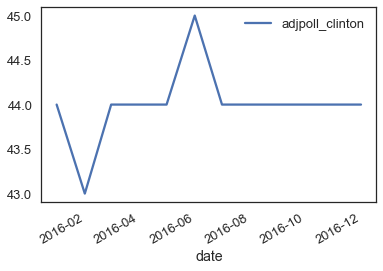

Opinion Poll for Trump vs month of the tweet


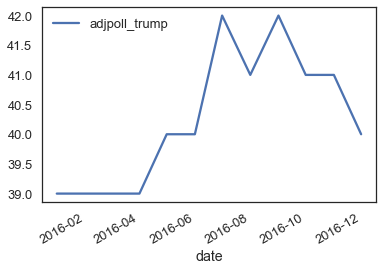

In [97]:
# some basic plots
import matplotlib.pyplot as plt

df = tweets_df.groupby(["date", "username", "retweets", "pscore", "adjpoll_clinton", "adjpoll_trump"]).size().reset_index().rename(columns={0:'count'})
df = df.loc[df['date'].between("2016-01-01", "2016-12-01", inclusive=True) ]

print("Opinion Poll for Clinton vs month of the tweet")
df.plot(x="date", y="adjpoll_clinton")
plt.show()

print("Opinion Poll for Trump vs month of the tweet")
df.plot(x="date", y="adjpoll_trump")
plt.show()

In [ ]:
We see from the opnion poll vs months during election period, Clintons opinions increase in the months June and July 2016 and flatline after that. 
But for Trump we see that poll ratings increase gradually from April to October of 2016, 
post which the election results are announced and then poll ratings started to fall.

In [98]:
## Plots for TRUMP poll data
trump_old = df.loc[df.username == "realDonaldTrump"]
trump_old = trump_old.groupby(["date", "username", "retweets", "adjpoll_trump"], as_index=False)['pscore'].mean()
trump = df.groupby(["date", "username", "retweets", "adjpoll_trump"]).size().reset_index().rename(columns={0: 'count'})
trump = pd.merge(left=trump,right=trump_old, left_on=["date", "username", "retweets", "adjpoll_trump"], right_on=["date", "username", "retweets", "adjpoll_trump"])
trump = trump[["date", "username", "retweets", "pscore", "adjpoll_trump"]]

trump.adjpoll_trump = trump.adjpoll_trump*100/(trump.retweets)
trump.retweets = trump.retweets * 1000/sum(trump.retweets)
trump = trump.loc[trump.retweets <=6]
trump.pscore = trump.pscore * 1000/sum(trump.pscore)

Opinion Poll for Trump vs month of the tweet


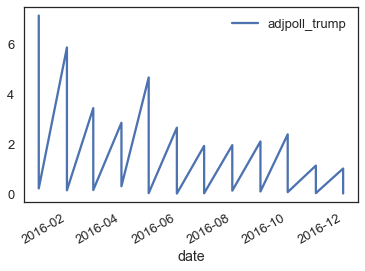

Afinn score and retweets VS month of the tweet


C:\Users\Divya\AppData\Roaming\Python\Python36\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


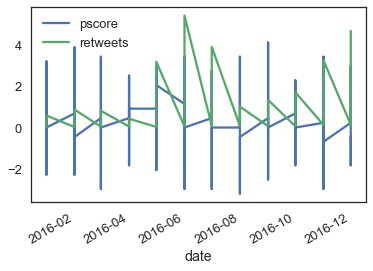

Afinn score and opinion poll data for trump VS month of the tweet


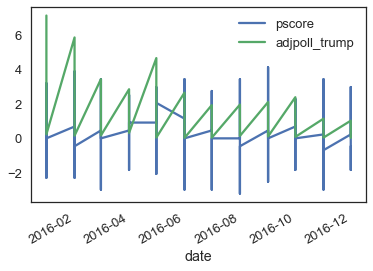

Retweets and opinion poll data for trump VS month of the tweet


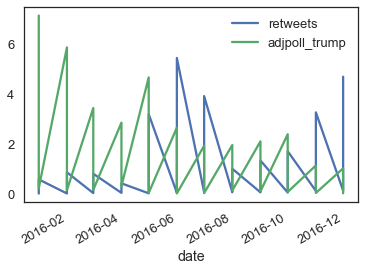

In [99]:
print("Opinion Poll for Trump vs month of the tweet")
trump.plot(x="date", y="adjpoll_trump")
plt.show()

print("Afinn score and retweets VS month of the tweet")
trump.plot(x = "date", y=["pscore", "retweets"])
plt.show()

print("Afinn score and opinion poll data for trump VS month of the tweet")
trump.plot(x = "date", y=["pscore", "adjpoll_trump"])
plt.show()

print("Retweets and opinion poll data for trump VS month of the tweet")
trump.plot(x = "date", y=["retweets", "adjpoll_trump"])
plt.show()

In [100]:
## Plots for CLINTON poll data
## Plots for TRUMP poll data
clinton_old = df.loc[df.username == "HillaryClinton"]
clinton_old = clinton_old.groupby(["date", "username", "retweets", "adjpoll_clinton"], as_index=False)['pscore'].mean()
clinton = df.groupby(["date", "username", "retweets", "adjpoll_clinton"]).size().reset_index().rename(columns={0: 'count'})
clinton = pd.merge(left=clinton,right=clinton_old, left_on=["date", "username", "retweets", "adjpoll_clinton"], right_on=["date", "username", "retweets", "adjpoll_clinton"])
clinton = clinton[["date", "username", "retweets", "pscore", "adjpoll_clinton"]]
clinton.adjpoll_clinton = clinton.adjpoll_clinton*10/(clinton.retweets)
clinton.retweets = clinton.retweets * 1000/sum(clinton.retweets)
clinton = clinton.loc[clinton.retweets <=6]
clinton.pscore = clinton.pscore*1000/sum(clinton.pscore)

Opinion Poll for Clinton vs month of the tweet


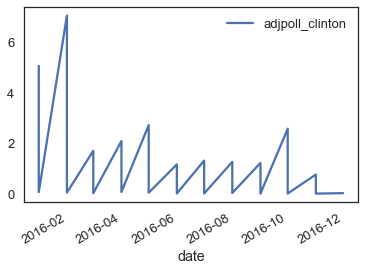

Afinn score and retweets VS month of the tweet


C:\Users\Divya\AppData\Roaming\Python\Python36\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


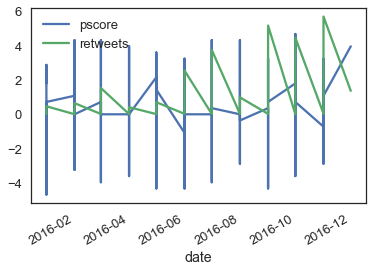

Afinn score and opinion poll data for Clinton VS month of the tweet


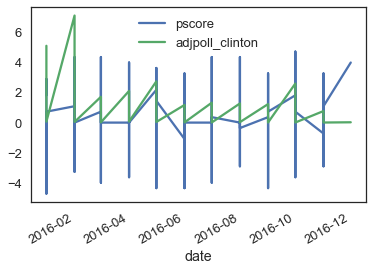

Retweets and opinion poll data for Clinton VS month of the tweet


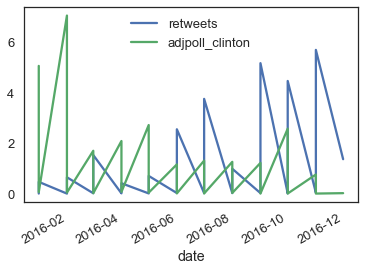

In [101]:
print("Opinion Poll for Clinton vs month of the tweet")
clinton.plot(x="date", y="adjpoll_clinton")
plt.show()

print("Afinn score and retweets VS month of the tweet")
clinton.plot(x = "date", y=["pscore", "retweets"])
plt.show()

print("Afinn score and opinion poll data for Clinton VS month of the tweet")
clinton.plot(x = "date", y=["pscore", "adjpoll_clinton"])
plt.show()

print("Retweets and opinion poll data for Clinton VS month of the tweet")
clinton.plot(x = "date", y=["retweets", "adjpoll_clinton"])

plt.show()

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [103]:
# Fitting a model
df = tweets_df.loc[tweets_df['date'].between("2016-01-01", "2016-12-01", inclusive=True) ]
trump = df.loc[df["username"] == "realDonaldTrump"]
clinton = df.loc[df["username"] == "HillaryClinton"]

In [104]:
from sklearn.svm import SVC

# TRUMP DATA
X = trump[["pscore"]] 
y = trump["adjpoll_trump"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
# train classifier
clf = SVC(probability=True, kernel='rbf')
clf.fit(X_train, y_train)

# predict and evaluate predictions
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.43438219493476593


In [105]:
# THE SAME DONE ON CLINTON'S DATA
X = clinton[["pscore"]] 
y = clinton["adjpoll_clinton"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

# train classifier
clf = SVC(probability=True, kernel='rbf')
clf.fit(X_train, y_train)

# predict and evaluate predictions
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.829000577700751


In [106]:
COLUMNS = ["positive", "negative"]
tweets_df.loc[:, "positive"] = 0
tweets_df.loc[:, "negative"] = 0
for index, row in df.iterrows():
    if row["pscore"] < 0:
        tweets_df.at[index, "negative"] = 1
    elif row["pscore"] >= 0:
        tweets_df.at[index, "positive"] = 1

In [107]:
# df.text = df.text.apply(lambda row: preprocess_input(row))

trump_new = tweets_df.loc[tweets_df.username == "realDonaldTrump"]
clinton_new = tweets_df.loc[tweets_df.username == "HillaryClinton"]

In [108]:
import string
from nltk.corpus import stopwords
stop = stopwords.words('english')

def clean_text(text):
    text = re.sub('[{}]'.format(string.punctuation), ' ', text.lower())
    return ' '.join([word for word in text.split() if word not in (stop)])


from collections import Counter
word_counter1 = {}
word_counter2 = {}
categ = "pscore"
d = Counter()
trump_new['text'].apply(lambda t: d.update(clean_text(t).split()))    
word_counter1[categ] = pd.DataFrame.from_dict(d, orient='index')\
                                    .rename(columns={0: 'count'})\
                                    .sort_values('count', ascending=False)

clinton_new['text'].apply(lambda t: d.update(clean_text(t).split()))    
word_counter2[categ] = pd.DataFrame.from_dict(d, orient='index')\
                                    .rename(columns={0: 'count'})\
                                    .sort_values('count', ascending=False)

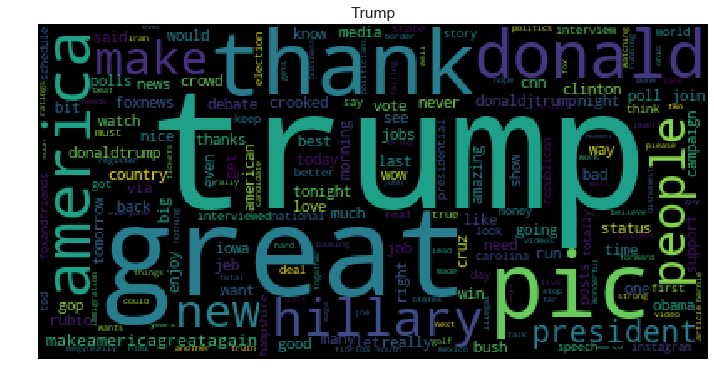

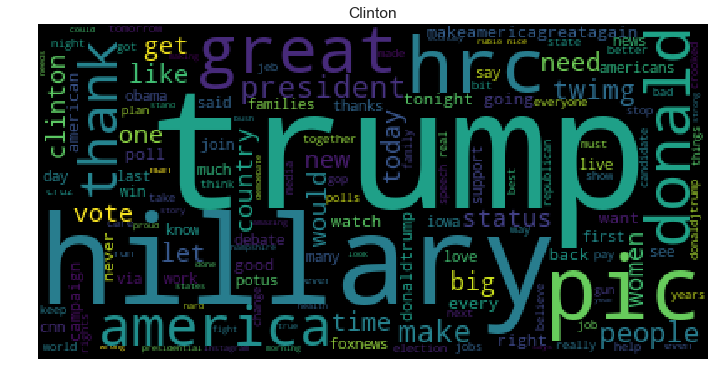

In [109]:
from wordcloud import WordCloud

wc1 = word_counter1[categ]
wc2 = word_counter2[categ]

wordcloud1 = WordCloud(
      background_color='black',
      max_words=200,
      max_font_size=100, 
      random_state=4561
     ).generate_from_frequencies(wc1.to_dict()['count'])

wordcloud2 = WordCloud(
      background_color='black',
      max_words=200,
      max_font_size=100, 
      random_state=4561
     ).generate_from_frequencies(wc2.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title("Trump")
plt.imshow(wordcloud1)
plt.axis('off')

fig = plt.figure(figsize=(12, 8))
plt.title("Clinton")
plt.imshow(wordcloud2)
plt.axis('off')

plt.show()